# Testing use scale and unscaled

In [1]:
import os
import time
import torch
import argparse
import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from collections import defaultdict
import torch.multiprocessing as mp
import torch.utils.data
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from sklearn import preprocessing


sides_3 = np.load('../data/force_torque_sensor/Dataset/3_sides/Data/data.npy')

dataset = sides_3[:,0:10]

device = torch.device('cuda:0')
print(type(dataset))

print(np.shape(sides_3))


<class 'numpy.ndarray'>
(1585353, 12)


In [2]:
def feature_normalize(data):
    mu = np.mean(data,axis=0)
    std = np.std(data,axis=0)
    return (data - mu)/std

def un_normalize(normalized_data, input_data):
    mu = np.mean(input_data,axis=0)
    std = np.std(input_data,axis=0)
    return normalized_data*std+mu

In [3]:
def extract_trials(x, n):
#     x = feature_normalize(x)
    x = preprocessing.minmax_scale(x, feature_range=(0,1))
    trials=[]
    trial=[]
    compare=0
    for sig in x:
        trial.append(sig[0:n])
        if sig[11] <= compare:
            d = 1002 - len(trial)
            if d >0:
                for i in range(d):
                    trial.append(np.zeros(len(sig[0:n])))
            trials.append(trial)
            trial=[]
        compare=sig[11]
    trials = np.array(trials)
    return trials       


In [4]:
num=10

sides_3_trials = extract_trials(sides_3, num)

print(np.shape(sides_3_trials))

(1583, 1002, 10)


In [5]:
sides_3_trials = sides_3_trials[0:1580]
dataset = sides_3_trials

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 5

test_loader = DataLoader(dataset=dataset, batch_size=batch_size)


In [6]:
def loss_fn(recon_x, x, mean, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x.view(-1, 1002*10), x.view(-1, 1002*10), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    # elbo = recon_loss + self.beta * D_kl
    elbo = (BCE + KLD)/ x.size(0)
    return elbo

## Method 1: End to End to generate(use encoder and decoder)

In [7]:
vae = torch.load('vae_all_signals_1002_scale_0_1_unscale.pkl').to(device)

import torch.utils.data


recon_signals=[]
latent_space=[]

for iteration, test in enumerate(test_loader):
    test = test.view(test.size(0), -1)
    test = test.to(device).float()
    test_recon_x, test_mean, test_log_var, test_z = vae(test)
    test_recon_x = test_recon_x.view(batch_size, 1002, 10)
    test_recon_x=test_recon_x.cpu().detach().numpy()
    latent_space=test_z.cpu().detach().numpy()

    recon_signals.extend(test_recon_x)
#     latent_space.extend(latent_space)
    
#     if iteration ==10:
#         break
    
recon_signals = np.array(recon_signals)
latent_space = np.array(latent_space)

In [8]:
print(type(recon_signals[0]))
print(recon_signals[0])

print(len(recon_signals))
print(np.shape(recon_signals))
# print(recon_signals)

<class 'numpy.ndarray'>
[[0.79119194 0.16128671 0.48313686 ... 0.82002306 0.6457678  0.58360314]
 [0.79018533 0.16090955 0.4821089  ... 0.8315564  0.6398581  0.60026515]
 [0.79079485 0.16018873 0.4764036  ... 0.8231534  0.63004714 0.5833709 ]
 ...
 [0.7890427  0.21055643 0.4803552  ... 0.8089949  0.58933395 0.62498134]
 [0.69764864 0.272365   0.46888518 ... 0.6979724  0.56122935 0.5182352 ]
 [0.02882388 0.01310786 0.01822252 ... 0.02541874 0.02031561 0.01880947]]
1580
(1580, 1002, 10)


In [9]:
generate_signals=[]
for trial in recon_signals:
    generate_signals.extend(trial)
generate_signals = np.array(generate_signals)

print(np.shape(generate_signals))
print(len(generate_signals))

(1583160, 10)
1583160


In [10]:
for i in range(len(generate_signals[0])):
    generate_signals[:,i]=preprocessing.minmax_scale(
        generate_signals[:,i], feature_range=(np.min(sides_3[:,i]),np.max(sides_3[:,i])))
    
generated_signals=generate_signals

print(generated_signals[100])

[ 5.9552016e-03 -5.5790944e-03  1.2752120e-04  1.2308374e-02
  2.2310591e+00  6.2714520e+00  7.0975876e-01  1.8256021e-01
  4.0858424e-01  8.0518961e-02]


In [11]:
print(len(generate_signals))
    

1583160


1583160


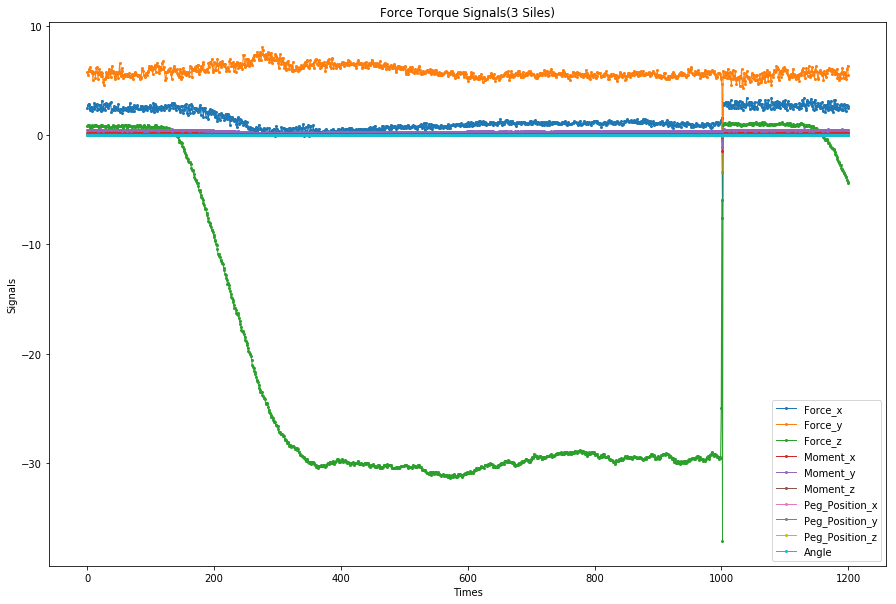

In [21]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

cmap=plt.cm.get_cmap(plt.cm.viridis,143)


# plt.rcParams['font.size'] = 11.
# plt.rcParams['font.family'] = 'Comic Sans MS'
# plt.rcParams['axes.labelsize'] = 15.
# plt.rcParams['xtick.labelsize'] = 10.
# plt.rcParams['ytick.labelsize'] = 10.

plt.figure(figsize=(15,10))



sides = generated_signals
print(len(sides))

first = 0
slip = 1200

# Peg_Position_x = sides[:,0]
Peg_Position_x = sides[:,0][first:slip]
# Peg_Position_x = sides[:,0][0:10:slip]

# Peg_Position_y = sides[:,1]
Peg_Position_y = sides[:,1][first:slip]
# Peg_Position_y = sides[:,1][0:10:slip]

# Peg_Position_z = sides[:,2]
Peg_Position_z = sides[:,2][first:slip]
# Peg_Position_z = sides[:,2][0:10:slip]

# Angle = sides[:,3]
Angle = sides[:,3][first:slip]
# Angle = sides[:,3][0:10:slip]

# Force_x = sides[:,4]
Force_x = sides[:,4][first:slip]
# Force_x = sides[:,4][0:10:slip]

# Force_y = sides[:,5]
Force_y = sides[:,5][first:slip]
# Force_y = sides[:,5][0:10:slip]

# Force_z = sides[:,6]
Force_z = sides[:,6][first:slip]
# Force_z = sides[:,6][0:10:slip]

# Moment_x = sides[:,7]
Moment_x = sides[:,7][first:slip]
# Moment_x = sides[:,7][0:10:slip]

# Moment_y = sides[:,8]
Moment_y = sides[:,8][first:slip]
# Moment_y = sides[:,8][0:10:slip]

# Moment_z = sides[:,9]
Moment_z = sides[:,9][first:slip]
# Moment_z = sides[:,9][0:10:slip]


# # Time = sides[:,10]
# Time = sides[:,10][first:slip]
# # Time = sides[:,10][0:10:slip]

# # Counter = sides[:,11]
# Counter = sides[:,11][first:slip]
# # Counter = sides[:,11][0:10:slip]

# # print(Counter[1001])
# print(min(Counter))
# print(max(Counter))


# x = Time
x = np.linspace(0,len(Moment_z),len(Moment_z))

plt.plot(x, Force_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_x')
plt.plot(x, Force_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_y')
plt.plot(x, Force_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_z')

plt.plot(x, Moment_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_x')
plt.plot(x, Moment_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_y')
plt.plot(x, Moment_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_z')

plt.plot(x, Peg_Position_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_x')
plt.plot(x, Peg_Position_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_y')
plt.plot(x, Peg_Position_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_z')

plt.plot(x, Angle, marker='o', linestyle='-', markersize=2, linewidth=1, label='Angle')
# plt.plot(x, Counter, marker='o', linestyle='-', markersize=2, linewidth=1, label='Counter')


plt.xlabel('Times')
plt.ylabel('Signals')
plt.title('Force Torque Signals(3 Siles)')
plt.legend(loc='lower right')
plt.show()

## Methods 2: Inference to generate(use latent space and decoder)

[[-0.60906696  1.4304338 ]
 [ 0.0511299   2.2276158 ]
 [ 0.9859439   0.14930137]
 [-1.500049   -2.5394907 ]
 [ 1.4880286  -1.3167028 ]]


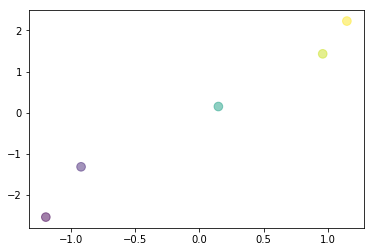

In [13]:
print(latent_space)

import matplotlib.pyplot as plt
import numpy as np
X = latent_space[:,0]
Y = latent_space[:,1]

colors = np.arctan(Y,X) # color

plt.scatter(X, Y, s=75, c=colors, alpha=.5)

tensor([[ 1.7409,  0.4990],
        [-1.4799, -0.1631],
        [-0.3475, -2.0595],
        [ 0.5284,  0.1361],
        [-0.0521, -0.4310]], device='cuda:0')


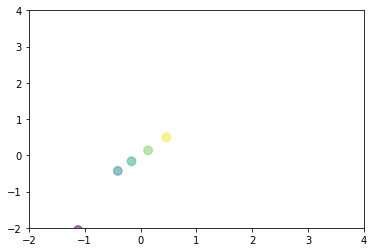

In [14]:
# batch_size = 10
z = torch.randn([batch_size, 2]).to(device)

visual_z = z.cpu().numpy()
import matplotlib.pyplot as plt
import numpy as np
X = visual_z[:,0]
Y = visual_z[:,1]

colors = np.arctan(Y,X) # color

plt.scatter(X, Y, s=75, c=colors, alpha=.5)
plt.xlim(-2,4)
plt.ylim(-2,4)

print(z)

In [15]:
recon_x = vae.decoder(z)


In [16]:
print(type(recon_x[0]))
print(recon_x[0])

print(len(recon_x))
print(len(recon_x[0]))

print(recon_x[0])

<class 'torch.Tensor'>
tensor([0.1717, 0.7389, 0.4645,  ..., 0.0171, 0.0133, 0.0129], device='cuda:0',
       grad_fn=<SelectBackward>)
5
10020
tensor([0.1717, 0.7389, 0.4645,  ..., 0.0171, 0.0133, 0.0129], device='cuda:0',
       grad_fn=<SelectBackward>)


In [17]:
recon_x = recon_x.view(batch_size,1002,10)
# generate_signals = recon_x.cpu().detach().numpy()

z_generate_signals=[]
for trial in recon_x:
    trial = trial.cpu().detach().numpy()
    z_generate_signals.extend(trial)
z_generate_signals = np.array(z_generate_signals)


# print(np.shape(generate_signals))
print(len(z_generate_signals))
# print(generate_signals[0])
# print(type(generate_signals))


5010


In [18]:
for i in range(len(z_generate_signals[0])):
    z_generate_signals[:,i]=preprocessing.minmax_scale(
        z_generate_signals[:,i], feature_range=(np.min(sides_3[:,i]),np.max(sides_3[:,i])))
    
z_generated_signals=z_generate_signals

print(len(z_generated_signals))
print(np.shape(z_generated_signals))

5010
(5010, 10)


5010


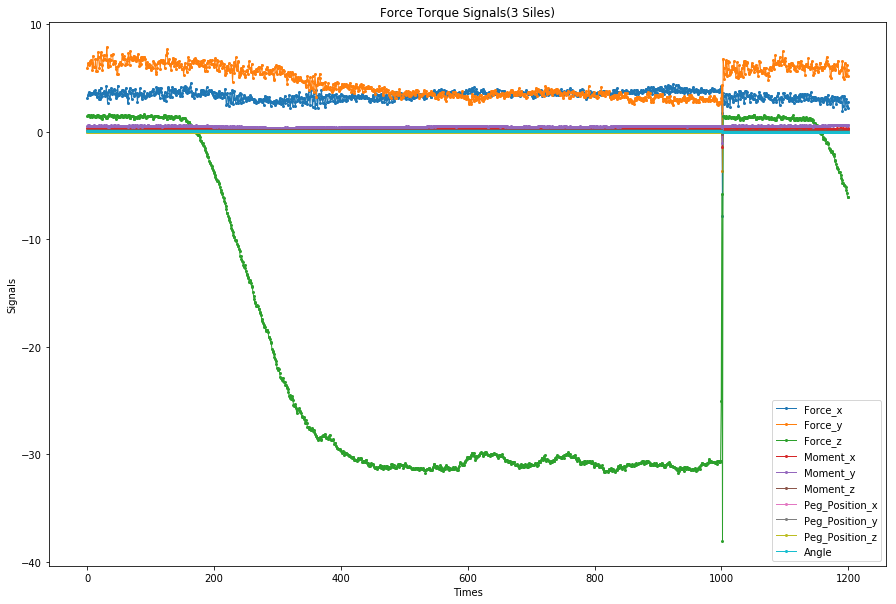

In [19]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

cmap=plt.cm.get_cmap(plt.cm.viridis,143)


# plt.rcParams['font.size'] = 11.
# plt.rcParams['font.family'] = 'Comic Sans MS'
# plt.rcParams['axes.labelsize'] = 15.
# plt.rcParams['xtick.labelsize'] = 10.
# plt.rcParams['ytick.labelsize'] = 10.

plt.figure(figsize=(15,10))



sides = z_generated_signals
print(len(sides))

first = 0
slip = 1200

# Peg_Position_x = sides[:,0]
Peg_Position_x = sides[:,0][first:slip]
# Peg_Position_x = sides[:,0][0:10:slip]

# Peg_Position_y = sides[:,1]
Peg_Position_y = sides[:,1][first:slip]
# Peg_Position_y = sides[:,1][0:10:slip]

# Peg_Position_z = sides[:,2]
Peg_Position_z = sides[:,2][first:slip]
# Peg_Position_z = sides[:,2][0:10:slip]

# Angle = sides[:,3]
Angle = sides[:,3][first:slip]
# Angle = sides[:,3][0:10:slip]

# Force_x = sides[:,4]
Force_x = sides[:,4][first:slip]
# Force_x = sides[:,4][0:10:slip]

# Force_y = sides[:,5]
Force_y = sides[:,5][first:slip]
# Force_y = sides[:,5][0:10:slip]

# Force_z = sides[:,6]
Force_z = sides[:,6][first:slip]
# Force_z = sides[:,6][0:10:slip]

# Moment_x = sides[:,7]
Moment_x = sides[:,7][first:slip]
# Moment_x = sides[:,7][0:10:slip]

# Moment_y = sides[:,8]
Moment_y = sides[:,8][first:slip]
# Moment_y = sides[:,8][0:10:slip]

# Moment_z = sides[:,9]
Moment_z = sides[:,9][first:slip]
# Moment_z = sides[:,9][0:10:slip]


# # Time = sides[:,10]
# Time = sides[:,10][first:slip]
# # Time = sides[:,10][0:10:slip]

# # Counter = sides[:,11]
# Counter = sides[:,11][first:slip]
# # Counter = sides[:,11][0:10:slip]

# # print(Counter[1001])
# print(min(Counter))
# print(max(Counter))


# x = Time
x = np.linspace(0,len(Moment_z),len(Moment_z))

plt.plot(x, Force_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_x')
plt.plot(x, Force_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_y')
plt.plot(x, Force_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_z')

plt.plot(x, Moment_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_x')
plt.plot(x, Moment_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_y')
plt.plot(x, Moment_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_z')

plt.plot(x, Peg_Position_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_x')
plt.plot(x, Peg_Position_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_y')
plt.plot(x, Peg_Position_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_z')

plt.plot(x, Angle, marker='o', linestyle='-', markersize=2, linewidth=1, label='Angle')
# plt.plot(x, Counter, marker='o', linestyle='-', markersize=2, linewidth=1, label='Counter')


plt.xlabel('Times')
plt.ylabel('Signals')
plt.title('Force Torque Signals(3 Siles)')
plt.legend(loc='lower right')
plt.show()